# Transform Consistency Loss

In [1]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A few things to fix:
- Understanding the paper
- Loading the data
- Converting the handedness
- Converting between different extrinsic formats and choosing great names for them
- Understanding the sources of NaN - perspective division and taking a log of a negative number

How I was able to do all of these things in 1/2 a day:
- Writing lots of little tests

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [4]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [5]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [6]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [7]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
    return output

In [30]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_q = torch.from_numpy(self.rgbs[idx+0].copy()[:500,:]).permute(2, 0, 1) / 255
        image_0 = torch.from_numpy(self.rgbs[idx+1].copy()[:500,:]).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()[:500,:]).permute(2, 0, 1) / 255
        # Our depth images i
        depth_q = torch.from_numpy(self.depths[idx+0].copy()[:500,:] * 1000)
        depth_0 = torch.from_numpy(self.depths[idx+1].copy()[:500,:] * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy()[:500,:] * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        # axes = torch.eye(4).double()
        # Our poses
        extrinsic_q = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_0 = torch.from_numpy(self.transforms[idx+1]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+2]) @ axes
        
        transform_q0 = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_q1 = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_01 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        # resize = torchvision.transforms.Resize((600 // 2, 400 // 2))
        resize = torchvision.transforms.Resize((250,400))
        return (
            self.K.unsqueeze(0),
            resize.forward(image_q),
            resize.forward(image_0),
            resize.forward(image_1),
            resize.forward(depth_q.unsqueeze(0)).squeeze(),
            resize.forward(depth_0.unsqueeze(0)).squeeze(),
            resize.forward(depth_1.unsqueeze(0)).squeeze(),
            transform_q0.float(),
            transform_q1.float(),
            transform_01.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

In [9]:
memmap = load_data_as_memmap('data-2023-03-03.npz', tempfile.mkdtemp())

In [31]:
dataset = CarlaTriplesDataset(memmap)

In [32]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]

torch.allclose(transform_q0, transform_from_params(params_from_transform(transform_q0.unsqueeze(0))))

True

### Testing the DataLoader

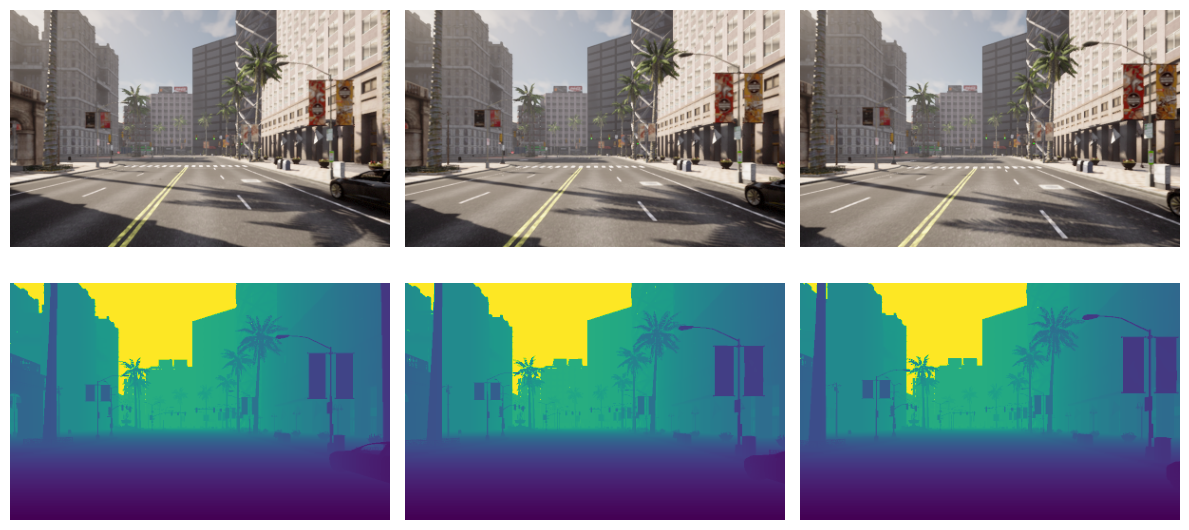

In [33]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[23]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.ravel():
    ax.axis('off')
axs[0, 0].imshow(image_q.permute(1, 2, 0))
axs[0, 1].imshow(image_0.permute(1, 2, 0))
axs[0, 2].imshow(image_1.permute(1, 2, 0))
axs[1, 0].imshow(torch.log(depth_q))
axs[1, 1].imshow(torch.log(depth_0))
axs[1, 2].imshow(torch.log(depth_1))
plt.tight_layout()
plt.show()
# import PIL
# from PIL import Image
# def tensor_to_image(tensor):
#     tensor = tensor*255
#     tensor = np.array(tensor.permute(1, 2, 0), dtype=np.uint8)
#     if np.ndim(tensor)>3:
#         assert tensor.shape[0] == 1
#         tensor = tensor[0]
#     return PIL.Image.fromarray(tensor)

# im1 = tensor_to_image(image_q)
# im2 = tensor_to_image(image_0)
# im3 = tensor_to_image(image_1)
# im1.save('pic4.png')
# im2.save('pic5.png')
# im3.save('pic6.png')


## Perspective Geometry

In [34]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [35]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [36]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [37]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [38]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [39]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [40]:
def reproject(depth, image, K, transform):
    """
    Backproject a depth map and transform it into the reference frame of a new camera
    defined by K, R, t by resampling the image.
    """
    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output

In [41]:
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[71]  # 71, 65, 21, 5

# image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q0).squeeze()
# image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q1).squeeze()

# fig, axs = plt.subplots(3, 2, figsize=(14, 10))
# for a in axs.ravel():
#     a.axis('off')
# axs[0, 0].imshow(image_0.permute(1,2,0))
# axs[0, 1].imshow(image_1.permute(1,2,0))
# axs[1, 0].imshow(image_q0.permute(1,2,0))
# axs[1, 1].imshow(image_q1.permute(1,2,0))
# axs[2, 0].imshow(image_q.permute(1,2,0))
# plt.tight_layout()
# plt.show()

### Testing Perspective Geometry

Let's see if we can project image_0 into image_1.

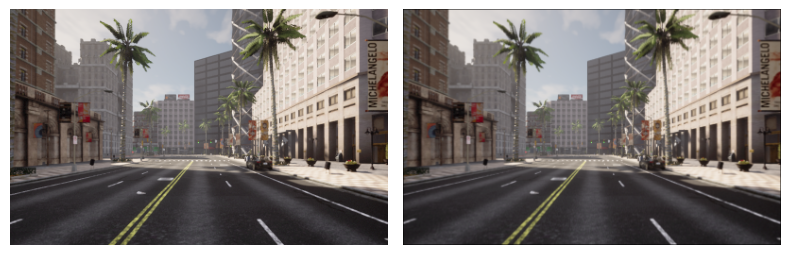

In [42]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]

identity = torch.eye(4)
image_r = reproject(depth_q, image_q.unsqueeze(0), dataset.K, identity).squeeze()

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for a in axs.ravel():
    a.axis('off')
axs[0].imshow(image_q.permute(1,2,0))
axs[1].imshow(image_r.permute(1,2,0))
plt.tight_layout()
plt.show()

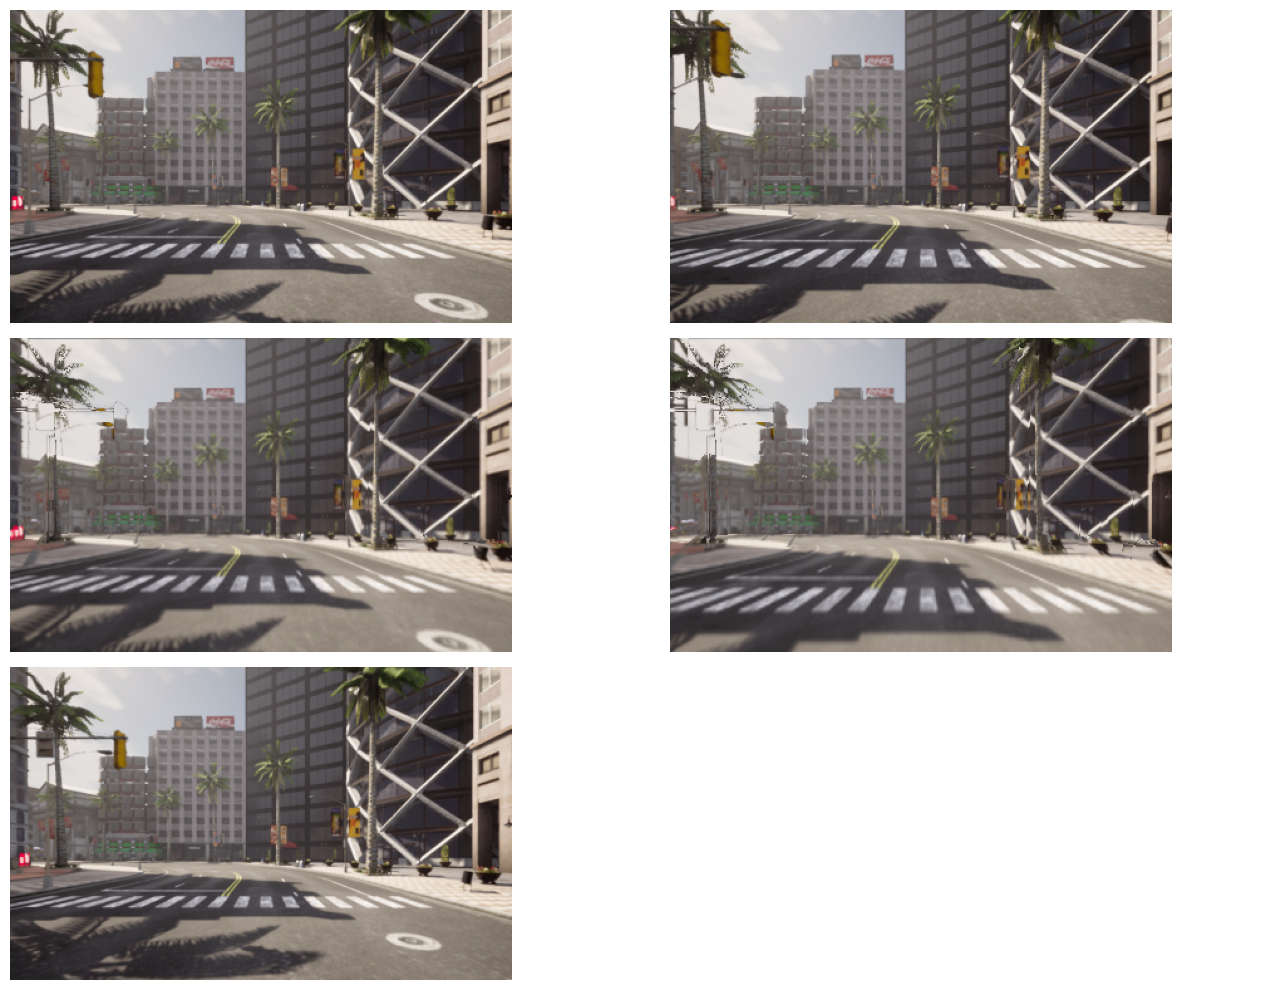

In [43]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[65]  # 71, 65, 21, 5

image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q0).squeeze()
image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q1).squeeze()

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
axs[2, 0].imshow(image_q.permute(1,2,0))
plt.tight_layout()
plt.show()



## Gauss-Newton

In [44]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        R = residuals(x)
        # We need nan_to_num in case there are no errors..!
        J = torch.autograd.functional.jacobian(residuals, x)
        # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
        J = (j.sum(0, keepdim=True) for j in J)
        R = (-torch.atleast_1d(r) for r in R)
        # J.mT @ J, J.mT @ r
        u = torch.stack([
            torch.linalg.lstsq(j, -r).solution
            for j, r in zip(J, R)
        ])
        # Update x, but do nothing if the solution is bad
        x = x + damping * u.nan_to_num(0)  # continue iterating
        # if J.sum() ==0:
        #     print("jacobian is 0", "\n x", x, "\nr", r, "\nJ", J)
    return x

In [45]:
def align_feature_maps(K, features_q, saliency_q, features_r, saliency_r, depth_r, delta):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        features_estimated = reproject(depth_r, features_r, K, transform)
        saliency_estimated = reproject(depth_r, saliency_r, K, transform)
        errors = torch.nn.functional.huber_loss(features_q, features_estimated, reduction='none', delta=delta)
        errors = saliency_estimated * saliency_q * errors
        return tuple(error.sum() for error in errors)
    return residuals

In [46]:
def align_images(K, image_q, image_r, depth_r):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        image_est = reproject(depth_r, image_r, K, transform)
        errors = torch.nn.functional.huber_loss(image_q, image_est, reduction='none', delta=1)
        return tuple(error.sum() for error in errors)
    return residuals

In [47]:
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = next(iter(dataloader_test))  # 71, 65, 21, 5

In [48]:
transform_q0

tensor([[[ 1.0000e+00,  2.4282e-05, -1.7063e-04,  1.0408e-04],
         [-2.4282e-05,  1.0000e+00, -1.4473e-08,  3.8394e-05],
         [ 1.7063e-04,  1.8619e-08,  1.0000e+00,  1.1259e+00],
         [-7.0123e-19,  7.3726e-23,  4.7455e-18,  1.0000e+00]],

        [[ 1.0000e+00,  1.9195e-05,  6.0475e-04, -1.2918e-04],
         [-1.9195e-05,  1.0000e+00, -1.9842e-07,  3.8025e-05],
         [-6.0475e-04,  1.8682e-07,  1.0000e+00,  1.1259e+00],
         [-3.7199e-19,  3.5765e-22, -1.0101e-21,  1.0000e+00]],

        [[ 9.9977e-01,  1.5818e-03, -2.1547e-02,  9.3277e-03],
         [-1.5851e-03,  1.0000e+00, -1.3526e-04,  5.5311e-05],
         [ 2.1547e-02,  1.6938e-04,  9.9977e-01,  1.1261e+00],
         [-1.4025e-18, -1.8556e-20,  2.5927e-19,  1.0000e+00]]])

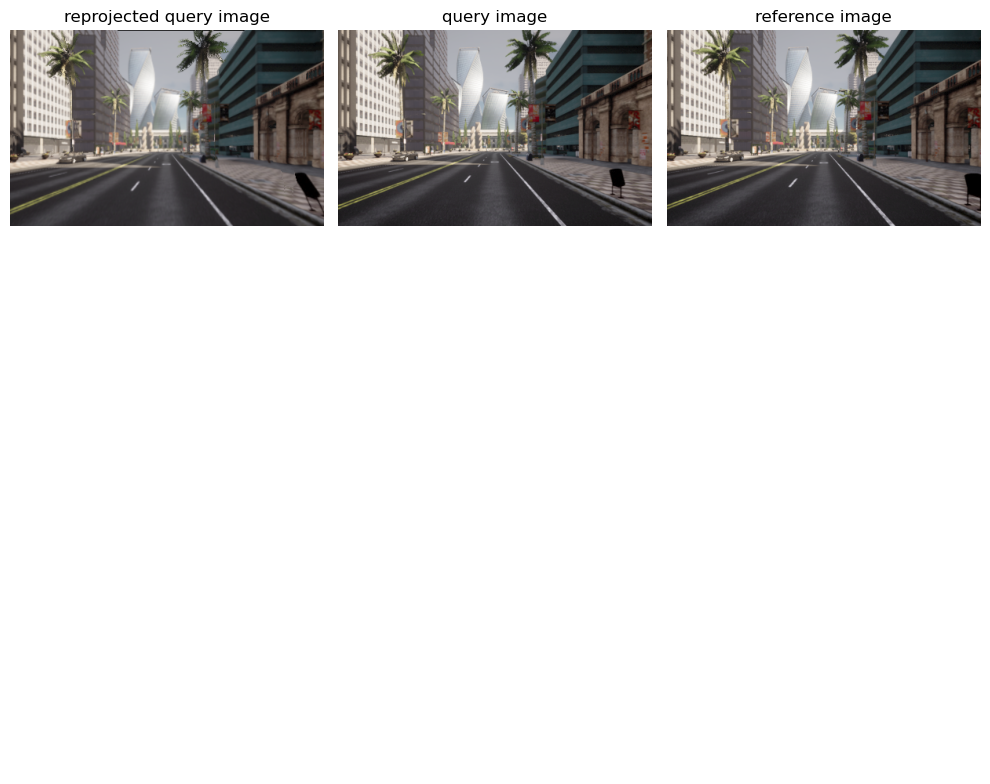

In [49]:
# guess = torch.zeros(len(K), 6)
guess = params_from_transform(transform_q0)

residual = align_images(K, image_q, image_0, depth_0)
estimate = gauss_newton(guess, residual, damping=0.01, iterations=10)
image_q0 = reproject(depth_q, image_q, K, transform_from_params(estimate).unsqueeze(1))
fig, axs = plt.subplots(len(K), 3, figsize=(10, 8))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].set_title('reprojected query image')
axs[0, 1].set_title('query image')
axs[0, 2].set_title('reference image')
for i in range(0, 1):
    axs[i, 0].imshow(image_q0[i].permute(1,2,0))
    axs[i, 1].imshow(image_q [i].permute(1,2,0))
    axs[i, 2].imshow(image_0 [i].permute(1,2,0))
plt.tight_layout()
plt.show()

In [61]:
K.shape, image_q.shape, image_0.shape, depth_0.shape,transform_q0.shape

(torch.Size([3, 1, 3, 3]),
 torch.Size([3, 3, 250, 400]),
 torch.Size([3, 3, 250, 400]),
 torch.Size([3, 250, 400]),
 torch.Size([3, 4, 4]))

## Loss Functions

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [62]:
def transform_consistency_loss(T_q0, T_q1, T_01):
    T_1q = torch.linalg.inv(T_q1)
    transform_consistency = T_01.to(T_q0.device) @ T_1q @ T_q0
    return torch.abs(se3_log_map(transform_consistency.mT).mean())

In [63]:
se3_log_map(torch.eye(4).view(1,4,4))

tensor([[0., 0., 0., 0., 0., 0.]])

### Test Transform Consistency

In [64]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[8]
transform_consistency_loss(transform_q0.unsqueeze(0), transform_q1, transform_01)  

tensor(1.3136e-05)

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [65]:
def transform_accuracy_loss(T_hat, T_inv_est):
    transform_accuracy = T_hat @ T_inv_est.to(T_hat.device)
    return torch.abs(se3_log_map(transform_accuracy.mT).mean())

In [66]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]
transform_accuracy_loss(transform_01.unsqueeze(0), torch.linalg.inv(transform_01).squeeze())

tensor(4.2476e-11)

## Data Loader

In [67]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [44]:
import datetime
# from tensorflow import summary
# import tensorflow as tf
# %load_ext tensorboard

## Training block

In [74]:
from torch.optim import Adam

net = UNet(3, 17).to(device)
net.train()

loss_history = []

damping = torch.tensor(0.05, requires_grad=False, device=device)

optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 5e-4},
    # {'params': damping, 'lr': 5e-4},
], lr=5e-4)

epochs = range(0, 1)

for e in epochs:
    
    lambd = 10.0 if e < 10 else 1.0
    
    progress = tqdm.tqdm(dataloader)

    for batch in progress:
        loss = 0
        optimizer.zero_grad()

        # set query image and 2 reference image
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1, T_q0, T_q1, T_01 = (
            x.to(device)
            for x in batch
        )
        T_10 = torch.linalg.inv(T_01)

        # set inital guess as identity rot-vec. and 0 translation
        result_q0 = torch.zeros(len(K), 6, device=device)  # params_from_transform(T_q0)
        result_q1 = torch.zeros(len(K), 6, device=device)  # params_from_transform(T_q1)
        result_01 = torch.zeros(len(K), 6, device=device)  # params_from_transform(T_01)
        
        pyramid_q = net.forward(image_q)
        pyramid_0 = net.forward(image_0)
        pyramid_1 = net.forward(image_1)
        levels = [0, 1, 2, 3]
        iterations = [16, 12, 8, 4]

        for level in levels:
            features_q, saliency_q = pyramid_q[level]
            features_0, saliency_0 = pyramid_0[level]
            features_1, saliency_1 = pyramid_1[level]

            # Resample depth maps for pyramid
            size = features_q.shape[-2:]
            depth_0_ = torchvision.transforms.functional.resize(depth_0, size).unsqueeze(0)
            depth_1_ = torchvision.transforms.functional.resize(depth_1, size).unsqueeze(0)

            # Align image_0 to query image
            residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.02)
            result_q0 = gauss_newton(result_q0, residuals_q0, iterations=iterations[level], damping=abs(damping))
            T_q0_est = transform_from_params(result_q0)

            # Align image_1 to query image
            residuals_q1 = align_feature_maps(K, features_q, saliency_q, features_1, saliency_1, depth_1_, delta=0.02)
            result_q1 = gauss_newton(result_q1, residuals_q1, iterations=iterations[level], damping=abs(damping))
            T_q1_est = transform_from_params(result_q1)

            # Compute transform consistency loss
            loss += transform_consistency_loss(T_q0_est, T_q1_est, T_01)
            loss += transform_consistency_loss(T_q1_est, T_q0_est, T_10)

            # Align image_0 to image_1
            residuals_01 = align_feature_maps(K, features_0, saliency_0, features_1, saliency_1, depth_1_, delta=0.02)
            result_01 = gauss_newton(result_01, residuals_01, iterations=iterations[level], damping=abs(damping))
            T_01_est = transform_from_params(result_01)
            # Compute transform accuracy loss
            loss += lambd * transform_accuracy_loss(T_10, T_01_est)
                        
            if loss.isnan():
                raise ValueError("Loss is NaN!")
        
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        # with train_summary_writer.as_default():
        #     tf.summary.scalar('loss', loss.item(), step=e)
        progress.set_postfix({'loss': loss.item(), 'damping': damping.item(), 'lambda': lambd})


  0%|          | 0/498 [00:00<?, ?it/s]

output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.req

  0%|          | 0/498 [00:00<?, ?it/s]

output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.requires_grad True
features_estimated.requires_grad True
output.requires_grad True
output.req

ValueError: All elements of `transform[:, :3, 3]` should be 0.

In [34]:
torch.save(net.state_dict(), "weights.pth")

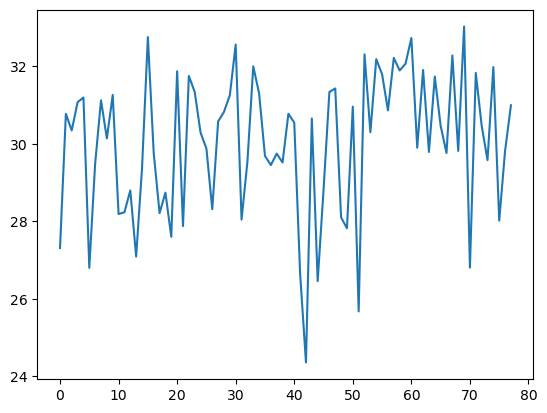

In [35]:
# # load trained Unet
# # net = UNet(3, 17).to(device)
# # net.load_state_dict(torch.load('unet_3.pth'))
plt.plot(loss_history)
plt.show()

In [36]:
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [37]:
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = (
    x.to(device)
    for x in next(iter(dataloader_test))
)

transform_10 = torch.linalg.inv(transform_01)

# set inital guess as identity rot-vec. and 0 translation
result_q0 = torch.zeros(len(K), 6, device=device) # params_from_transform(transform_q0) # 
result_q1 = torch.zeros(len(K), 6, device=device) # params_from_transform(transform_q1) # 

with torch.no_grad():
    pyramid_q = net.forward(image_q.to(device))
    pyramid_0 = net.forward(image_0.to(device))

for level in levels:
    features_q, saliency_q = pyramid_q[level]
    features_0, saliency_0 = pyramid_0[level]
    
    # Resample depth maps for pyramid
    size = features_q.shape[-2:]
    depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    # Align image_0 to query image
    residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, delta=0.02)
    result_q0 = gauss_newton(result_q0, residuals_q0, iterations=iterations[level], damping=0.05)
    print(transform_from_params(result_q0))

transform_q0_est = transform_from_params(result_q0)

tensor([[[ 0.9907, -0.1192, -0.0659,  0.0086],
         [ 0.1317,  0.9618,  0.2402, -0.1328],
         [ 0.0347, -0.2466,  0.9685,  0.1524],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([[[ 0.9984, -0.0185,  0.0541,  0.0172],
         [ 0.0146,  0.9973,  0.0716, -0.1806],
         [-0.0552, -0.0707,  0.9960,  0.2348],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([[[ 0.9999,  0.0046,  0.0106,  0.0153],
         [-0.0059,  0.9916,  0.1289, -0.2037],
         [-0.0099, -0.1289,  0.9916,  0.2642],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([[[ 0.9958,  0.0749,  0.0524,  0.0139],
         [-0.0794,  0.9927,  0.0903, -0.2246],
         [-0.0453, -0.0941,  0.9945,  0.2760],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')


In [38]:
transform_q0_est

tensor([[[ 0.9958,  0.0749,  0.0524,  0.0139],
         [-0.0794,  0.9927,  0.0903, -0.2246],
         [-0.0453, -0.0941,  0.9945,  0.2760],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

In [39]:
# reproject using pose_q0_est
reprojected_query_image = reproject(depth_q.to(device), image_q.to(device), K.to(device), transform_q0_est)

Text(0.5, 1.0, 'query image')

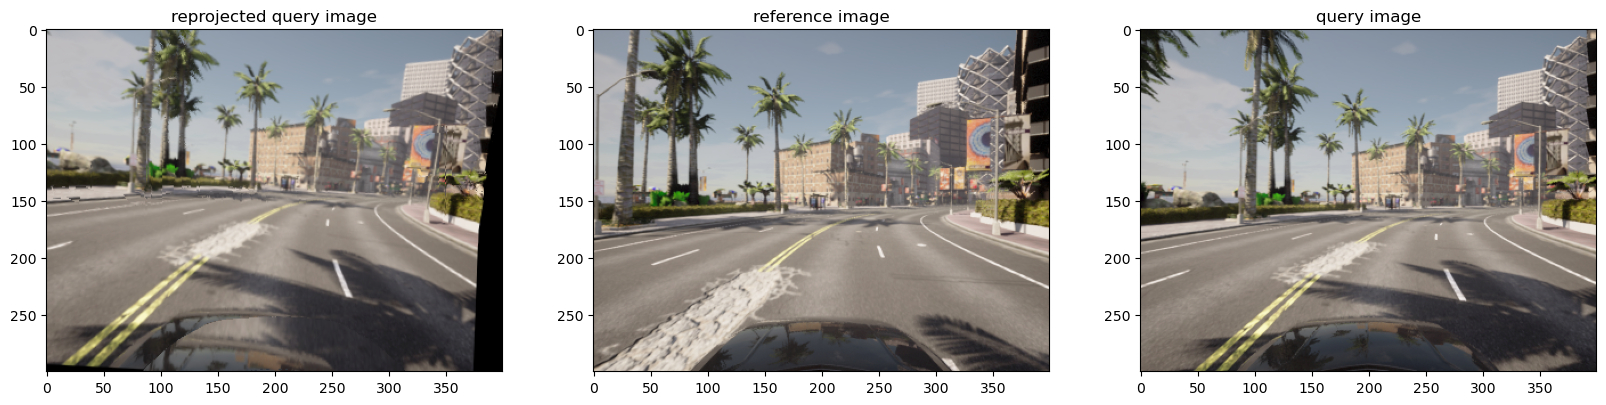

In [40]:
fig,ax =  plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(reprojected_query_image.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[1].imshow(image_0.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[2].imshow(image_q.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[0].set_title('reprojected query image')
ax[1].set_title('reference image')
ax[2].set_title('query image')